#  Supervised Regression Objective

**🎯 Objective:** Predict the **total invoice amount** based on purchase and product details.

- **Target variable:** `Invoice_Amount`

## Step 1: Import Libraries

In [1]:
import pyodbc
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

## Step 2: Connect to SQL Server Data Warehouse

In [2]:
# SQL Server connection settings (using Windows Authentication)
server = 'localhost'  # e.g., 'localhost' or your server name
database = 'DW_Monoprix'  # Change to your target Data Warehouse
driver = '{ODBC Driver 17 for SQL Server}'

# Create connection string and connect
connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

## Step 3: Query Data from Table

In [3]:
query = """ SELECT
    F.Invoice_Amount,
    F.Invoice_VATRate,
    F.Product_Price,
    F.Product_RecommendedProfitMargin,
    F.InvoiceItems_Quantity, 
    C.BK_Category AS Category, 
    S.Country, 
    S.City, 
    P.Origin, 
    DATEDIFF(day, InvDate.FullDate, InvDueDate.FullDate) AS Delay_Invoice, 
    DATEDIFF(day, PsDate.FullDate, PayDueDate.FullDate) AS Delay_Payment 
 FROM Fact_SupplierManagement F 
 LEFT JOIN DimSupplier S ON F.SupplierID = S.PK_Supplier 
 LEFT JOIN DimProduct P ON F.ProductID = P.PK_Product 
 LEFT JOIN DimCategory C ON F.CategoryID = C.PK_Category 
 LEFT JOIN DimDate InvDate ON F.InvoiceDateID = InvDate.PK_Date 
 LEFT JOIN DimDate InvDueDate ON F.InvoiceDueDateID = InvDueDate.PK_Date 
 LEFT JOIN DimDate PayDueDate ON F.InvoicePaymentDueDateID = PayDueDate.PK_Date 
 LEFT JOIN DimDate PsDate ON F.PsDateID = PsDate.PK_Date 
 WHERE F.Invoice_Amount IS NOT NULL
 """

# Load the pre-joined data directly from SQL
df = pd.read_sql(query, conn)

# Replace NaN/NULL in numeric columns with 0
df[['Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment','Invoice_Amount']] = df[[
    'Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment','Invoice_Amount'
]].fillna(0)

# Replace NaN/NULL in categorical columns with 'UNSPECIFIED'
df[['Origin', 'Category']] = df[['Origin', 'Category']].fillna('UNSPECIFIED')
df[['Country', 'City']] = df[['Country', 'City']].fillna('UNKNOWN')

df


C:\Users\aneek\AppData\Local\Temp\ipykernel_27084\832715767.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Invoice_Amount,Invoice_VATRate,Product_Price,Product_RecommendedProfitMargin,InvoiceItems_Quantity,Category,Country,City,Origin,Delay_Invoice,Delay_Payment
0,3212.00,5.5,54.30,22.20,10.0,Boisson,France,Paris,FRANCE,15,0.0
1,157.00,10.0,82.80,25.75,9.0,Boisson,France,Paris,FRANCE,81,0.0
2,1056.00,0.0,0.00,NaN,NaN,UNSPECIFIED,France,Paris,UNSPECIFIED,43,0.0
3,1971.00,20.0,48.71,39.76,6.0,Textile,France,Paris,FRANCE,35,-1041.0
4,521.00,0.0,0.00,NaN,NaN,UNSPECIFIED,France,Paris,UNSPECIFIED,21,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10287,3.13,0.0,0.00,NaN,NaN,UNSPECIFIED,,,UNSPECIFIED,0,0.0
10288,3310.83,0.0,0.00,NaN,NaN,UNSPECIFIED,,,UNSPECIFIED,0,0.0
10289,209.30,0.0,0.00,NaN,NaN,UNSPECIFIED,,,UNSPECIFIED,0,0.0
10290,2.53,0.0,0.00,NaN,NaN,UNSPECIFIED,,,UNSPECIFIED,0,0.0


## Step 4: Preprocess the Data

In [4]:
df_clean = df.dropna()
df_encoded = pd.get_dummies(df_clean, columns=['Country', 'City', 'Origin', 'Category'], drop_first=True)

In [5]:
X = df_encoded.drop(columns=["Invoice_Amount"])
y = df_encoded["Invoice_Amount"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Train and Evaluate Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"  MSE: {mse_lr:.2f}")
print(f"  MAE: {mae_lr:.2f}")
print(f"  R²:  {r2_lr:.4f}")

Linear Regression:
  MSE: 2352192.04
  MAE: 1290.80
  R²:  0.0780


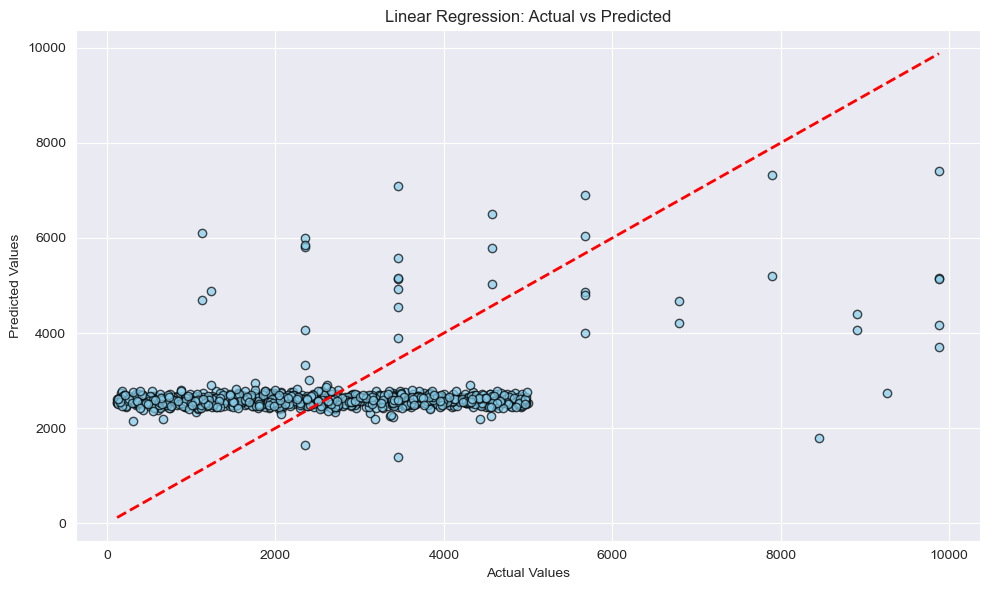

In [8]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='skyblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 6: Train and Evaluate Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest:")
print(f"  MSE: {mse_rf:.2f}")
print(f"  MAE: {mae_rf:.2f}")
print(f"  R²:  {r2_rf:.4f}")


Random Forest:
  MSE: 2406694.84
  MAE: 1296.22
  R²:  0.0566


## Step 7: Train and Evaluate XGBoost

In [10]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost:")
print(f"  MSE: {mse_xgb:.2f}")
print(f"  MAE: {mae_xgb:.2f}")
print(f"  R²:  {r2_xgb:.4f}")


XGBoost:
  MSE: 2483383.69
  MAE: 1307.63
  R²:  0.0265


## Step 8: Compare All Models

In [11]:
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "MSE": [mse_lr, mse_rf, mse_xgb],
    "MAE": [mae_lr, mae_rf, mae_xgb],
    "R²": [r2_lr, r2_rf, r2_xgb]
})

results_df.sort_values(by="R²", ascending=False)

,Model,MSE,MAE,R²
0,Linear Regression,2.352192e+06,1290.796956,0.077959
1,Random Forest,2.406695e+06,1296.216740,0.056594
2,XGBoost,2.483384e+06,1307.625252,0.026533


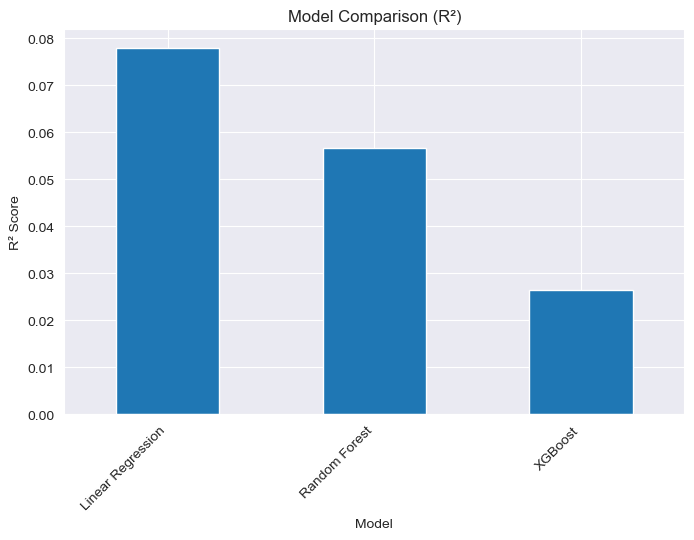

In [12]:
# Create the plot
ax = results_df[["R²"]].plot(kind="bar", title="Model Comparison (R²)", figsize=(8, 5), legend=False)

# Set labels
ax.set_xlabel("Model")
ax.set_ylabel("R² Score")

# Set x-tick labels for the models
ax.set_xticks(range(len(results_df)))  # One tick per model
ax.set_xticklabels(["Linear Regression", "Random Forest", "XGBoost"])

# Add grid
plt.grid(True)

# Add diagonal rotation to the labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

Best One is Linear Regression

## ✅ Save the Trained Linear Regression Model & Scaler

In [13]:
import joblib
from sklearn.preprocessing import StandardScaler

# Standardize your data before saving the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Retrain the model on the full dataset (optional but often better for deployment)
lr_final = LinearRegression()
lr_final.fit(X_scaled, y)

# Save the model and scaler
joblib.dump(lr_final, 'sro_purchasing_director_model.pkl')
joblib.dump(scaler, 'sro_purchasing_director_scaler.pkl')


['sro_purchasing_director_scaler.pkl']

## Use in Power BI (Python Script Visual or Data Transformation)

In [ ]:
import pandas as pd
import joblib

# Load trained model and scaler
lr_model = joblib.load('C:/Path/To/Your/sro_purchasing_director_model.pkl')
scaler = joblib.load('C:/Path/To/Your/sro_purchasing_director_scaler.pkl')

# Preprocess dataset (Power BI injects it as 'dataset')
dataset[['Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment', 'Invoice_Amount']] = dataset[[
    'Invoice_VATRate', 'Product_Price', 'Delay_Invoice', 'Delay_Payment', 'Invoice_Amount'
]].fillna(0)

dataset[['Origin', 'Category']] = dataset[['Origin', 'Category']].fillna('UNSPECIFIED')
dataset[['Country', 'City']] = dataset[['Country', 'City']].fillna('UNKNOWN')

# One-hot encode like in training
dataset_encoded = pd.get_dummies(dataset, columns=['Country', 'City', 'Origin', 'Category'], drop_first=True)

# Align features
model_columns = lr_model.feature_names_in_  # Available in sklearn 1.0+
missing_cols = set(model_columns) - set(dataset_encoded.columns)
for col in missing_cols:
    dataset_encoded[col] = 0
dataset_encoded = dataset_encoded[model_columns]

# Scale
X_scaled = scaler.transform(dataset_encoded)

# Predict
dataset['Predicted_Invoice_Amount'] = lr_model.predict(X_scaled)

# Output to Power BI
result = dataset[['Invoice_Amount', 'Predicted_Invoice_Amount']]  # Or more if needed
